<a href="https://colab.research.google.com/github/OmarMachuca851/Task/blob/main/trainUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net

## Problema 1: Aprendizaje y estimación

In [ ]:
from model import *
from data import *

In [ ]:
# Display CUDA version
print('CUDA version:', tf.test.is_built_with_cuda())

CUDA version: True


In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(1,'data/salt/train','images','masks',data_gen_args,save_to_dir = "data/salt/train/aug")
model = unet()
model_checkpoint = ModelCheckpoint('unet_salt.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=2,callbacks=[model_checkpoint])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 256, 256, 64) 640         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_386 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_385[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_65 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_386[0][0]                 
__________________________________________________________________________________________________
conv2d_387

In [ ]:
testGene = testGenerator("data/salt/test/images")
model = unet()
model.load_weights("unet_salt.hdf5")
results = model.predict_generator(testGene,300,verbose=1)
saveResult("data/salt/test/image",results)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_409 (Conv2D)             (None, 256, 256, 64) 640         input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_410 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_409[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_69 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_410[0][0]                 
__________________________________________________________________________________________________
conv2d_411

## Problema 2: Lectura del código

Todo el modelo está definido en **Unet-master/model.py**

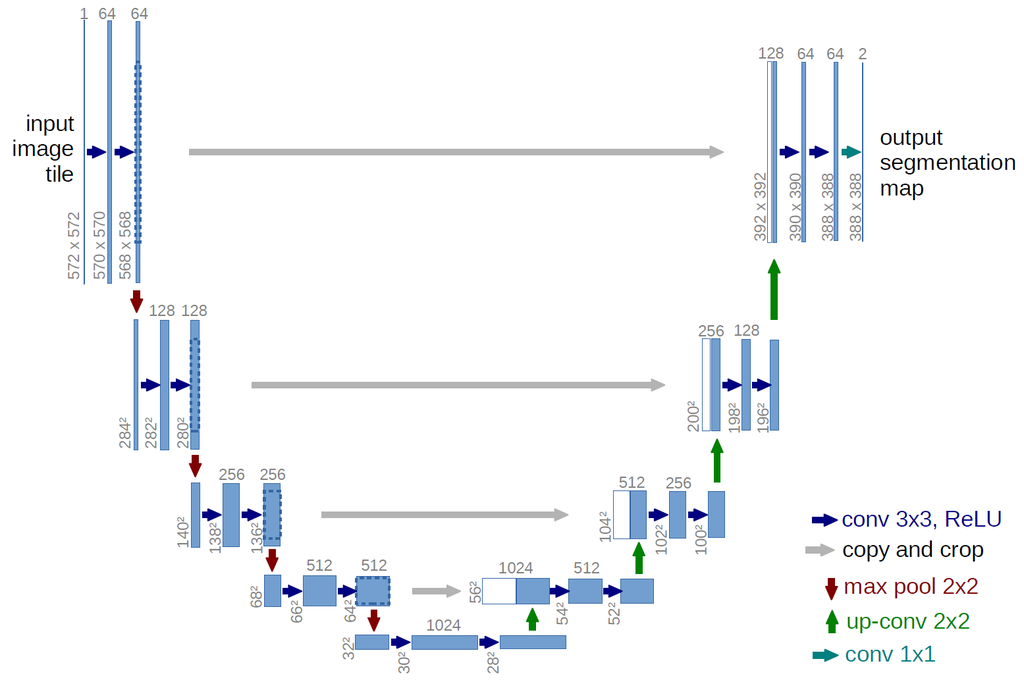

se puede ver que el modelo sigue el esquema de la imagen:

- **Convolución y agrupación:**  
Se ingresa una imagen y se realiza una convolución de 3x3 `conv1 = Conv2D(64, 3, ...)(inputs)`, que extrae características importantes de la imagen. A continuación, utilizamos la agrupación máxima de 2x2 `pool1 = MaxPooling2D(pool_size=(2, 2))(conv)` en las lineax  para reducir el tamaño de los datos y hacer que los cálculos sean más eficientes.
- **Escalado por deconvolución:**  
Como es un modelo simetrico para devolver los datos reducidos mediante agrupación a su tamaño original se reemplaza maxpooling por deconvolución 2x2 (sobremuestreo) `up6 = Conv2D(512, 2, ...)(UpSampling2D(size = (2,2))(drop5))` en las líneas. Esto permite restaurar características más precisas. En la práctica, esta deconvolución permite una segmentación detallada de regiones.
- **Combinación (copia) de funciones:**  
Durante el proceso de deconvolución, se utiliza información de la misma capa antes de la convolución para complementar las características `merge6 = concatenate([drop4,up6], axis = 3)`, lo que permite recuperar parte de la información perdida en la etapa anterior. En la práctica, se ha demostrado que esto mejora la precisión.